# Convolutional Neural Networks (CNNs) Intro

This introduces convolutional layers to the basic neural network model. Usually you have a mix of convolutional layers with dense layers (or what PyTorch calls linear layers).

Typically, CNNs are used for image tasks. Although in recent years (current year being 2020), CNNs seems to be outperforming recurrent neural networks (RNNs) for handling sequential type of data.

In this intro, we will be looking at image data.

Unlike a typical dense layered NN, we can pass the image as is without having to flatten it. this includes 3D images.

The concept is that the convolutional layer will look for features in a kernel (a window of pixels from the image. for example, we could set the kernel to be a 3 pixel by 3 pixel for a 2D image of 100 pixels by 100 pixels). these features in the first convolutional layer could be edges, curves, and corners. then on the second layer, the features would be things that the patterns found on the first layer would build like circles, squares, etc. This process is called a convolution.

Once this is done on one kernel, the kernel slides through the image at set steps until it has gone through the entire image. ultimately condencing the image.

After the image is condenced, then pooling is done on the condenced data. the most common form of pooling is max pooling, which refers to extracting the maximum value of a kernel on the condenced data. Then as previously it done, the kernel will slide over the entire image until it has pooled the entire image.

## 



In [4]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [5]:
REBUILD_DATA = False # This is True if we need to rebuild the data, and false if we have already built it.

In [8]:
class DogsVsCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)): # f is the file name
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # Imports image, and turns it into grayscale
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]]) # This creates the training data by appending each image at a time. Notice that np.eye was used to create one-hot encoding of the label of each image. 

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                
                except Exception as e: # This catches errors for the images that did not work for the model
                    pass
                    # print(str(e))

        np.random.shuffle(self.training_data) # Shuffles in-place
        np.save("training_data.npy", self.training_data)
        print("Cats: ", self.catcount)
        print("Dogs: ", self.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVsCats()
    dogsvcats.make_training_data()

100%|██████████| 12501/12501 [00:38<00:00, 328.41it/s]
Cats:  12476
Dogs:  12470


In [9]:
training_data = np.load("training_data.npy", allow_pickle=True) # This loads back our training data, now that this is done we do not have to re run the class again to build the dataset. 
print(len(training_data))

24946


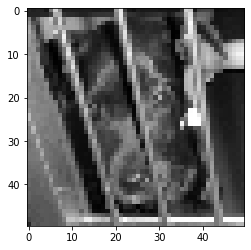

label=  [0. 1.]


In [15]:
import matplotlib.pyplot as plt

test_sample = training_data[1]

plt.imshow(test_sample[0], cmap="gray")
plt.show()

print("label= ", test_sample[1])

## Creating the Neural Network

### From Convolution Layer to Linear Layer

In CNNs, the convolutional layers eventually have to pass the data to linear layers which would be the distribution of predictions.

There is no good way of doing the previously mention. In TensorFlow, Keras takes care of this for us by flattening the data but in PyTorch we do not have the advatage of that. 

One way that we can do this for PyTorch is to pass data through, and then figure out what's the shape.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolution Layers
        self.conv1 = nn.Conv2d(1, 32, 5) # input= 1 image, output = 32 convolutional features, kernel size = 5 (meaning a 5x5 kernel)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50) # -1 however big the tensor, 1 image, 50 by 50 pixels (this is creating some random data to pass through the network to know the size of the flatten data to be passed through the linear layers)
        self._to_linear = None
        self.convs(x) # This is going to serve as part of our forward method

        # Linear Layers
        self.fc1 = nn.Linear(self._to_linear, 512) # Notice the shape of the input is that of the variable self._to_linear which is calculated by passing through a random test sample
        self.fc2 = nn.Linear(512, 2) # (output is 2 since we have 2 classes in this case)

    def convs(self, x): # Forward method for only the convolutional layers
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2)) # Activating the neuron through Relu, then pooling it with a shape of 2 by 2. 
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

        print(x[0].shape)

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2] # This checks the shape of the 0th element in the batch which is our random test sample, and gives the length of it flatten.
            return x

    def forward(self, x): # Forward method for the linear layers
        x = self.convs(x)
        x = x.view(-1, self._to_linear) # This changes the dimensions of the elements in the batch to be flattened
        x = F.relu(self.fc1(x)) # Passing it forward to the first linear layer
        x = self.fc2(x) # Passing it forward to the output layer of the network

        return F.softmax(x, dim= 1) # Activation fuction on the output

net = Net()


torch.Size([128, 2, 2])


In [18]:
import torch.optim as optim 

optimizer = optim.Adam(net.parameters(), lr= 0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50) # Creating a tensor of our images data
X = X/255.0 # Scaling the value of the pictures to be between 0 and 1
y = torch.Tensor([i[1] for i in training_data]) # Creating a tensor of our labels

VAL_PCT = 0.1 # Percentage of the data that will be our testing data
val_size = int(len(X)*VAL_PCT)

print(val_size)

2494


In [20]:
# Separating Training and Test data

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [23]:


BATCH_SIZE = 100 # If you are hitting memory errors, then change your batch size. This is usually the easiest way to resolve that problem in any other neural network. The lowest where you need to tweak the layers themselves should be about 8.

EPOCHS = 1

for epoc in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # defining each batch from 0th index up to but not including the 100th index, runned through the entire length of our training data
        # print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50) # shapping the batch of images to tensor size format
        batch_y = train_y[i:i+BATCH_SIZE]

        # Below there are two ways to zero your gradient, this comes down to how many optimizers are being used, depending on how many models are working together.
        #  optimizer.zero_grad() # This is how you zero the grad specific to the optimizer
        net.zero_grad() #This is how you zero the grad specific to the network model
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y) # Calculates loss
        loss.backward() # Back propagates the loss
        optimizer.setp()

print("Loss = ", loss)


0%|          | 0/225 [00:00<?, ?it/s]torch.Size([128, 2, 2])



AttributeError: 'NoneType' object has no attribute 'view'